In [1]:
from obspy.core.event import read_events
import obspy
import numpy as np
import pandas as pd
from scipy.special import sph_harm
import matplotlib.pyplot as plt
import os.path
import shutil
from obspy import UTCDateTime
from netCDF4 import Dataset
from matplotlib import cm
from skimage.filters import gaussian
from mpl_toolkits.basemap import Basemap
from itertools import chain

from scipy.stats import qmc
import h5py

dpi = 300
FigFormat = "png"

def draw_map(map):

    # draw a shaded-relief image
    map.shadedrelief(scale=0.2)
    
    # lats and longs are returned as a dictionary
    lats = map.drawparallels(np.linspace(-90, 90, 13))
    lons = map.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

Text(0.5, 1.0, 'Latin Hypercube Sampling (n = 30000)')

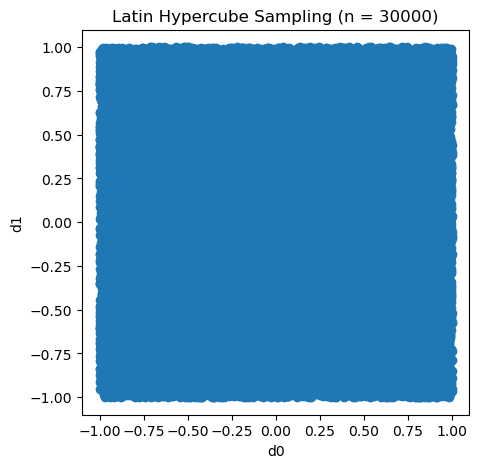

In [3]:
# Dim = 81*5*3+6
# N = 30000
# scalerange = 1
# sampler = qmc.LatinHypercube(d=Dim)
# sample = sampler.random(n=N)
# l_bounds = [-scalerange]*Dim
# u_bounds = [scalerange]*Dim
# sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
# np.save('sampling_array_%d_elastic' %N,sample_scaled)

# plt.figure(figsize=(5, 5))
# plt.scatter(sample_scaled[:, 0], sample_scaled[:, 1])
# plt.xlabel("d0")
# plt.ylabel("d1")
# plt.title(f"Latin Hypercube Sampling (n = {N})")

In [2]:
sample_scaled = np.load('sampling_array_30000_elastic.npy')

In [3]:

# num_models = 30000

# source_dims = (num_models, 6)
# with h5py.File('../DataSet/Elastic_Sources.h5', "w") as data_hdf5:
#     source_data = data_hdf5.create_dataset("source", source_dims, dtype='float32')

#     for imodel in np.arange(0,num_models):
#         print(f"Processing model {imodel}")
#         para_index = 0
#         MomentTensor = sample_scaled[imodel,para_index:para_index+6]*1e10
#         source_data[imodel, :] = np.array(MomentTensor)


Processing model 0
Processing model 1
Processing model 2
Processing model 3
Processing model 4
Processing model 5
Processing model 6
Processing model 7
Processing model 8
Processing model 9
Processing model 10
Processing model 11
Processing model 12
Processing model 13
Processing model 14
Processing model 15
Processing model 16
Processing model 17
Processing model 18
Processing model 19
Processing model 20
Processing model 21
Processing model 22
Processing model 23
Processing model 24
Processing model 25
Processing model 26
Processing model 27
Processing model 28
Processing model 29
Processing model 30
Processing model 31
Processing model 32
Processing model 33
Processing model 34
Processing model 35
Processing model 36
Processing model 37
Processing model 38
Processing model 39
Processing model 40
Processing model 41
Processing model 42
Processing model 43
Processing model 44
Processing model 45
Processing model 46
Processing model 47
Processing model 48
Processing model 49
Processing

In [7]:
ExampleInputDir = '../Runs/ExampleSphericalHarmonicsElasticBall/input'

SourceDepthRange = [0,300]
DvpRange = 0.025
DvsRange = 0.025
DrhoRange = 0.025

for imodel in np.arange(1,2):

    para_index = 0

    ModeName = 'LatinSphericalHarmonicsElasticBall%04d' %imodel
    EventParDir='../Runs/%s' %(ModeName)  
    if not os.path.exists(EventParDir):
        os.makedirs(EventParDir)
    print(EventParDir, " created")

    if not os.path.exists(EventParDir+'/input'):
        os.makedirs(EventParDir+'/input')

    # copy parameter file
    # shutil.copy(ExampleInputDir+'/TomoNet_LowerMantle__10s.e',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.model.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.nr.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.advanced.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.source.yaml',EventParDir+'/input/')
    # update event source
    # EventDepth = (sample_scaled[imodel,para_index]+1)/2*(SourceDepthRange[1]-SourceDepthRange[0])+SourceDepthRange[0]
    # para_index += 1
    MomentTensor = sample_scaled[imodel,para_index:para_index+6]*1e10
    para_index += 6
    with open(EventParDir+'/input/inparam.source.yaml','r') as file:
        filetxt = file.read()
    # filetxt = filetxt.replace("latitude_longitude: [-56.24, 26.34]", "latitude_longitude: [%.2f, %.2f]" %(EventLat, EventLon))
    # filetxt = filetxt.replace("depth: 200.0e0", "depth: %.1fe0" %(EventDepth))
    filetxt = filetxt.replace("data: [1e10, 1e10, 1e10, 1e10, 1e10, 1e10]", "data: [%e, %e, %e, %e, %e, %e]"  %(MomentTensor[0], MomentTensor[1], MomentTensor[2], MomentTensor[3], MomentTensor[4], MomentTensor[5]))
    with open(EventParDir+'/input/inparam.source.yaml','w') as file:
        file.write(filetxt)

    shutil.copy(ExampleInputDir+'/inparam.output.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/Synthetic_Stations_Ball.txt',EventParDir+'/input/')

    # # generate random model
    ### Real spherical harmonics
    coeff = {}

    ModelCoeff = dict()
    ModelCoeff['variable'] = []
    ModelCoeff['Depth'] = []
    ModelCoeff['l'] = []
    ModelCoeff['m'] = []
    ModelCoeff['Value'] = []

    l_max = 8
    DepthList = [0. , 200, 400, 600, 800, 1000]

    for depth in DepthList:
        coeff[depth] = {}

    for variable in ['dvp','dvs','drho']:
        for depth in DepthList[0:-1]:
            
            for l in range(0,l_max+1):
                for m in np.arange(-l,l+1):
                    name = '%s_%s_%s' %(variable, l, m)
                    # print(l,m)
                    ModelCoeff['variable'].append(variable)
                    ModelCoeff['Depth'].append(depth)
                    ModelCoeff['l'].append(l)
                    ModelCoeff['m'].append(m)

                    if variable == 'dvp':
                        Val = sample_scaled[imodel,para_index]*DvpRange  # Latin Hypercube Sampling
                    elif variable == 'dvs':
                        Val = sample_scaled[imodel,para_index]*DvsRange  # Latin Hypercube Sampling
                    elif variable == 'drho':
                        Val = sample_scaled[imodel,para_index]*DrhoRange  # Latin Hypercube Sampling

                    ModelCoeff['Value'].append(Val)
                    coeff[depth][name] = Val 

                    para_index += 1

    df = pd.DataFrame(data=ModelCoeff)
    df.to_pickle(EventParDir+"/Spherical_Harmonics.pkl")

    grid_depth = np.array(DepthList)
    grid_lat = np.linspace(-90, 90, 181)
    grid_lon = np.linspace(-180, 180, 361)

    # Make sure RADISU and Coordinates are ascendingly sorted
    grid_depth.sort()
    grid_lat.sort()
    grid_lon.sort()

    LON, LAT = np.meshgrid(grid_lon, grid_lat)
    DvpMLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])
    DvsMLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])
    DrhoMLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])

    for variable in ['dvp','dvs','drho']:
        for i, SlicingDepth in enumerate(DepthList):

            if SlicingDepth == 1000:
                DvpMLTomo[:,:,i] = 0
                DvsMLTomo[:,:,i] = 0
                DrhoMLTomo[:,:,i] = 0
                continue
            # initiate TomoSum
            TomoSum = np.zeros([len(grid_lat),len(grid_lon)])

            for l in range(0,l_max+1):
                for m in np.arange(-l,l+1):
                    # print('l, m = ', l, m)
                    name = '%s_%s_%s' %(variable, l, m)
                    Y_grid = sph_harm(m, l, np.radians(LON-180), np.radians(90-LAT))

                    if m < 0:
                        Y_grid = np.sqrt(2) * (-1)**(-m) * Y_grid.imag
                    elif m > 0:
                        Y_grid = np.sqrt(2) * (-1)**m * Y_grid.real

                    TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid
            if variable == 'dvp':
                DvpMLTomo[:,:,i] = TomoSum[:,:]
            elif variable == 'dvs':
                DvsMLTomo[:,:,i] = TomoSum[:,:]
            elif variable == 'drho':
                DrhoMLTomo[:,:,i] = TomoSum[:,:]
    
    print(DvpMLTomo.min(), DvpMLTomo.max())
    print(DvsMLTomo.min(), DvsMLTomo.max())
    print(DrhoMLTomo.min(), DrhoMLTomo.max())

    # # Fig Preparation
    # dpi = 200
    # fig = plt.figure(figsize=(3.5,3),dpi=200)
    # ax = fig.add_subplot(111)

    # map = Basemap(projection='moll',lon_0=0,resolution='l') # moll Projection
    # PLOT = map.pcolormesh(LON, LAT, TomoSum, latlon=True, cmap=plt.get_cmap('jet'))
    # cbar = plt.colorbar(PLOT, ax=ax, shrink=0.5)
    # ax.set_title('Depth Slice at %s m to degrees %d' %(SlicingDepth, l_max))
    # draw_map(map)
    # map.drawcoastlines(linewidth=0.1)

    NCName = "degree8_random.nc"
    # write to file
    if os.path.exists(EventParDir+'/input/'+NCName):
        os.remove(EventParDir+'/input/'+NCName)

    nc = Dataset(EventParDir+'/input/'+NCName, 'w')
    nc.createDimension('nlat', size=len(grid_lat))
    nc.createDimension('nlon', size=len(grid_lon))
    nc.createDimension('ndepth', size=len(grid_depth))
    nc.createVariable('latitude', float, dimensions=('nlat'))
    nc['latitude'][:] = grid_lat
    nc.createVariable('longitude', float, dimensions=('nlon'))
    nc['longitude'][:] = grid_lon
    nc.createVariable('depth', float, dimensions=('ndepth'))
    nc['depth'][:] = grid_depth
    nc.createVariable('dvp', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['dvp'][:,:,:] = DvpMLTomo[:,:,:]
    nc.createVariable('dvs', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['dvs'][:,:,:] = DvsMLTomo[:,:,:]
    nc.createVariable('drho', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['drho'][:,:,:] = DrhoMLTomo[:,:,:]

    if imodel == 0:
        nc['dvp'][:,:,:] = np.zeros(np.shape(DvpMLTomo[:,:,:]))
        nc['dvs'][:,:,:] = np.zeros(np.shape(DvsMLTomo[:,:,:]))
        nc['drho'][:,:,:] = np.zeros(np.shape(DrhoMLTomo[:,:,:]))
        nc.close()
        continue

    nc.close()



../Runs/LatinSphericalHarmonicsElasticBall0001  created


/tmp/ipykernel_7880/700414076.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


0 defined
0 defined
0 defined
-0.13872020890456213 0.12577690941273495
-0.1183123100580465 0.1074596265323829
-0.12274948173461356 0.1443581281019513
